# Optional Lab - Simple Neural Network
In this lab we will build a small neural network using Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [2]:
# importing numpy and matplotlib library
import numpy as np
import matplotlib.pyplot as plt

# using lab stylesheet
plt.style.use('./deeplearning.mplstyle')

# importing tensorflow library
import tensorflow as tf

# importing Sequential model which string mmany layers 
from tensorflow.keras.models import Sequential

# importing dense which is a type of layer in tensorflow
from tensorflow.keras.layers import Dense

# importing lab methods
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit

# enabling the logging for tensorflow
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


## DataSet

In [3]:
# this will datasets for coffee roast problem
# where X is the dataset 200 X 2 Matrix => 200 examples & 2 features
# Y is target values 200 X 1 Matrix => 200 target values
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

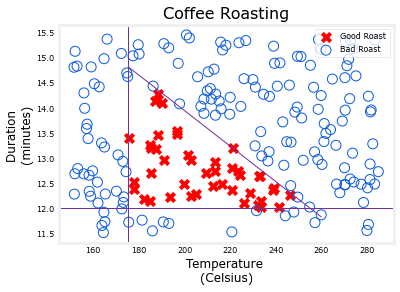

In [4]:
# will plot the roast coffee dataset
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [11]:
# printing the features before normalizng the dataset
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

# creates a normalization preprocessing layer
# uses the formula (input - mean) / sqrt(var) => similar to z-score (mean - input) / sigma
# axis=-1 means the last input shape/dimension will used
norm_l = tf.keras.layers.Normalization(axis=-1)

# computes the mean an variance from the dataset
norm_l.adapt(X)  # learns mean, variance

# will print the mean, variance
print(norm_l.get_weights())

# passing the dataset into the normalization layer
Xn = norm_l(X)

# printing the features after the normalizing the datasets
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
[array([218.67,  13.43], dtype=float32), array([1.60e+03, 1.27e+00], dtype=float32), 200]
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


2024-02-10 15:45:49.312343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2024-02-10 15:45:49.326688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [16]:
# increasing the dataset size by repeating the examples 1000 times
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   

print(f'The shapes before tile {Xn.shape}, {Y.shape}')

print(f'The shapes after tile {Xt.shape}, {Yt.shape}')

The shapes before tile (200, 2), (200, 1)
The shapes after tile (200000, 2), (200000, 1)


## Tensorflow Model

### Model
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

In [17]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# defines a sequeuntial model with 3 layers
# Layer 1- Input Layer = a0 with shape (2,) => 2 features tf.keras.Input(shape=(2,)), used to instantiate tf Tensor
# Layer 2- Hidden Layer 1 with 3 neuron
# Layer 3- Ouput Layer 1 with 1 neuron
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [19]:
# 2 features so they have w1, w2, 3 comes from the units/neurons in the layer 1, + 3 from the three b1, b2, b3 parameter
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters

# 3 from the layer 1 a1 and they have w1, w2, 1 comes from the units/neurons in the layer 2, + 1 from the b1 parameter
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [25]:
# extracts the parameters w, b from the two layers
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()

# printing the shape of each layer
print("Layer 1:")
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)

print("\nLayer 2:")
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

Layer 1:
W1(2, 3):
 [[-0.14  0.1  -0.25]
 [ 0.16 -0.32  0.3 ]] 
b1(3,): [0. 0. 0.]

Layer 2:
W2(3, 1):
 [[-0.55]
 [-0.25]
 [ 0.11]] 
b2(1,): [0.]


The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [26]:
# define what lost function to be used
# binary because there is 2 classes only
# optimizer is Adam which is type of gradient descent
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

# will train the model, run the gradient descent and find the best weights
# passing the normalized X, and y
# epochs number of times to go through the dataset
model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10


2024-02-10 16:10:44.659232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc

6250/6250 [==============================] - 34s 5ms/step - loss: 0.2342
Epoch 2/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1132
Epoch 3/10
6250/6250 [==============================] - 34s 5ms/step - loss: 0.0563
Epoch 4/10
6250/6250 [==============================] - 36s 6ms/step - loss: 0.0165
Epoch 5/10
6250/6250 [==============================] - 47s 8ms/step - loss: 0.0107
Epoch 6/10
6250/6250 [==============================] - 45s 7ms/step - loss: 0.0075
Epoch 7/10
6250/6250 [==============================] - 45s 7ms/step - loss: 0.0054
Epoch 8/10
6250/6250 [==============================] - 50s 8ms/step - loss: 0.0039
Epoch 9/10
6250/6250 [==============================] - 46s 7ms/step - loss: 0.0028
Epoch 10/10
6250/6250 [==============================] - 58s 9ms/step - loss: 0.0021


#### Epochs and batches
In the `fit` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

#### Updated Weights
After fitting, the weights have been updated: 

In [28]:
# getting the updated weights from the model
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()

# printing the newly computed weights
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-10.71  -0.08  15.2 ]
 [ -0.25  -9.17  12.59]] 
b1: [-11.63 -11.49   1.99]
W2:
 [[-48.84]
 [-45.33]
 [-40.28]] 
b2: [25.99]


You can see that the values are different from what you printed before calling `model.fit()`. With these, the model should be able to discern what is a good or bad coffee roast.

For the purpose of the next discussion, instead of using the weights you got right away, you will first set some weights we saved from a previous training run. This is so that this notebook remains robust to changes in Tensorflow over time. Different training runs can produce somewhat different results and the following discussion applies when the model has the weights you will load below. 

Feel free to re-run the notebook later with the cell below commented out to see if there is any difference. If you got a low loss after the training above (e.g. 0.002), then you will most likely get the same results.

In [ ]:
# After finishing the lab later, you can re-run all 
# cells except this one to see if your trained model
# gets the same results.

# Set weights from a previous run. 

# defining the parameters for layer 1
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])


# defining the parameters for layer 2
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])

# Replace the weights from your trained model with
# the values above.
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [29]:
# Check if the weights are successfully replaced
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-10.71  -0.08  15.2 ]
 [ -0.25  -9.17  12.59]] 
b1: [-11.63 -11.49   1.99]
W2:
 [[-48.84]
 [-45.33]
 [-40.28]] 
b2: [25.99]


### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [30]:
# defining sample 2 test examples
X_test = np.array([
    [200,13.9],  # positive example
    [200,17]])   # negative example

# normalizing the 2 test examples
X_testn = norm_l(X_test)

# making prediction with the model
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

2024-02-10 16:22:24.137052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


predictions = 
 [[9.89e-01]
 [6.05e-07]]


To convert the probabilities to a decision, we apply a threshold:

In [33]:
# create np array with the same shape as the predictions
yhat = np.zeros_like(predictions)

# loop over the predicions and threshold the values to be 0 or 1
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [39]:
# this be the same as before and will compare each each element in the prediction matrix
# but it's in one line
hat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.

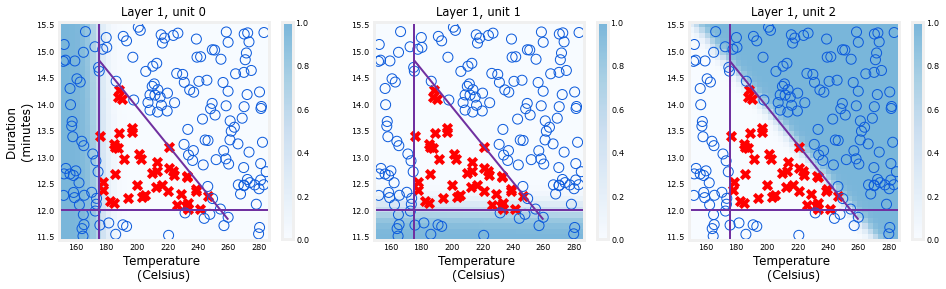

In [40]:
# will plot the features in each neuron of layer 1/first hidden layer
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

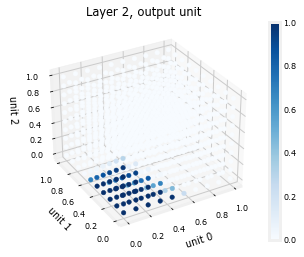

In [41]:
plt_output_unit(W2,b2)

The final graph shows the whole network in action.  
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  
The following takes a moment to run

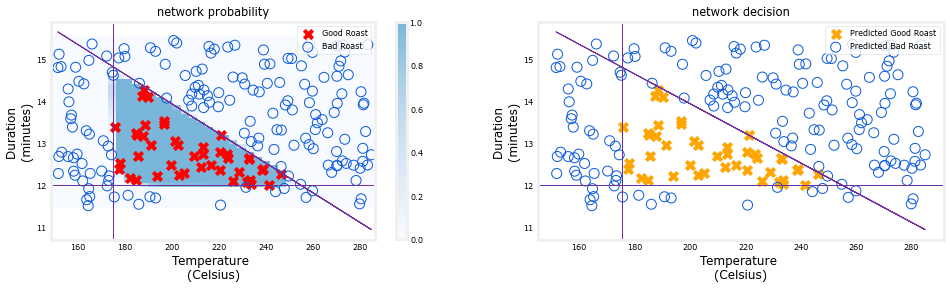

In [42]:
# normalizes all the inputs using lambda function
# x is just each example of the entire dataset
netf= lambda x : model.predict(norm_l(x))

# plotting the network using the actual dataset X. target value y, normalized predictions
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in Tensorflow. 
The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.